In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import zed
import ipaddress

Verbose = False
PrintImage = True
viz_threshold = 500
sample_size = 250

# Connect to the default lake at http://localhost:9867
client = zed.Client()

# Define the file name
file_name = 'second_cap.pcapng'

# Define the Zed query
ZQL_query = '_path=="conn" | cut id.orig_h, id.orig_p, id.resp_h, id.resp_p, proto | sort id.orig_h, id.resp_h'

# Execute the Zed query on the file directly
values = client.query(f'from {file_name} | {ZQL_query}')

# Convert the iterator to a list and then create a dataframe, flattening the JSON/dictionary structure
data_frame = pd.json_normalize(list(values))

#set total count of records:
total = len(data_frame)

In [2]:
# Determine graph size
def set_size(df, total, sample_size):
    """Evaluates the count of records to determine graph size to adjust visualization styling"""
    if total > viz_threshold: # Maxim visualization threshold
        print("Records exceed visualization threshold, taking %s samples\n" % (sample_size))
        df = df.sample(total=sample_size) # take random sample
        total=len(df) # recalculate record count    
    if ((total <= 500) and (total > 250)):
        size = 'huge'
    elif ((total <= 250) and (total > 150)):
        size = 'large'
    elif ((total <= 150) and (total > 100)):
        size = 'medium'
    elif ((total <= 100) and (total > 50)):
        size = 'small'
    else:
        size = 'tiny'
    return(df, size)
        
def describe_pandas_data(data_frame):
    print("\nFirst 5 records\n")
    print(data_frame.head(5))
    print("\nLast 5 records\n")
    print(data_frame.tail(5))
    print("\nData types\n")
    print(data_frame.dtypes)
    print("\nCheck for NaN fields\n")
    print(data_frame.isna().sum())
    print("\n")
    print("\nDescribe Data\n")
    print(data_frame.describe())
    print("\n")
    return

# CHECK FOR THE DATA IN DATA_FRAME:

In [3]:
#number of records (rows) that data_frame contains
print(len(data_frame))

44


In [4]:
# Display the first 10 rows of the DataFrame
data_frame.head(10)

,proto,id.orig_h,id.orig_p,id.resp_h,id.resp_p
0,udp,192.168.1.1,40703,239.255.255.250,1900
1,udp,192.168.1.134,5353,224.0.0.251,5353
2,udp,192.168.1.191,5353,224.0.0.251,5353
3,tcp,192.168.1.219,50166,3.223.248.73,443
4,tcp,192.168.1.219,50209,23.212.249.76,443
5,tcp,192.168.1.219,50208,23.212.249.76,443
6,tcp,192.168.1.219,49981,23.212.249.76,443
7,tcp,192.168.1.219,64994,31.13.66.2,443
8,tcp,192.168.1.219,65451,31.13.66.2,443
9,tcp,192.168.1.219,49180,31.13.66.2,443


In [5]:
#Which column and data types are in Dataframe?
data_frame.dtypes

proto        object
id.orig_h    object
id.orig_p     int64
id.resp_h    object
id.resp_p     int64
dtype: object

# Check empty field guide:
>Explanation of isna().sum();
> 1. df.isna() creates a boolean DataFrame where True indicates missing values;
> 2. df.isna().sum() computes the sum of True values for each column (axis 0 by default), effectively counting the number of missing values in each column.

In [6]:
#Check there is no emtpy field:
data_frame.isna().sum()

proto        0
id.orig_h    0
id.orig_p    0
id.resp_h    0
id.resp_p    0
dtype: int64

# DataFrame.dropna() guide:
Remove missing values from a DataFrame.

Parameters:
> axis: Determines whether rows (0 or 'index') or columns (1 or 'columns') containing missing values are removed.
0 or 'index': Drop rows which contain missing values.
1 or 'columns': Drop columns which contain missing values.

> how: Determines under what conditions rows or columns are removed from the DataFrame.
'any' (default): Drop the row or column if any NA values are present.
'all': Drop the row or column only if all values are NA.

> inplace: Whether to modify the DataFrame in place (True) or create a new one (False, default).
True to modify the DataFrame itself.
False to create a new DataFrame with missing values removed.


In [7]:
#If there is any empty cell, drop them:
data_frame.dropna(axis=0, how='any', inplace=True)

# Count number of distinct elements in a specific axis:

**DataFrame.nunique(axis=0, dropna=True)**  
Count number of distinct elements in specified axis.

- **axis**:  
  {0 or ‘index’, 1 or ‘columns’}, default 0  
  The axis to use. 0 or ‘index’ for row-wise, 1 or ‘columns’ for column-wise.

- **dropna**:  
  bool, default True  
  Don’t include NaN in the counts.


In [8]:
#check number of distinct host in id.orig_h col:
data_frame['id.orig_h'].nunique()

9

In [9]:
data_frame.describe()

,id.orig_p,id.resp_p
count,44.000000,44.000000
mean,41250.522727,1989.272727
std,21101.921502,3608.480273
min,8.000000,0.000000
25%,47060.750000,443.000000
50%,50195.500000,443.000000
75%,50706.750000,948.250000
max,65451.000000,19900.000000


# Returns a graph from Pandas DataFrame containing an edge list: 
## from_pandas_edgelist:
- Returns a graph from Pandas DataFrame containing an edge list.
- (df, source='source', target='target', edge_attr=None, create_using=None, edge_key=None)



In [10]:
# Set plt.figure.figsize based on sample size
# Total: total number of records
data_frame, size = set_size(data_frame, total, sample_size)
print("Graph Size: %s" % size)

Graph Size: tiny


In [11]:
#create the graph denotes the connections between hosts using networkx:
graph = nx.from_pandas_edgelist(data_frame, source='id.orig_h', target='id.resp_h', edge_attr=True, create_using=None, edge_key=None)

In [12]:
# Print debug data for networkx graph
def debug_graph_data(data_frame):
    print("\n Nodes in dataset \n")
    print(graph.nodes())
    print("\n Edges in dataset \n")
    print(graph.edges())
    print("\n Edges with data \n")
    print(graph.edges.data())
    print("\n Nodes and degree \n")
    print(graph.degree())
    print("\n is the graph directed? \n")
    print(graph.is_directed())
    print("\n is the graph weighted? \n")
    print(nx.is_weighted(graph))
    print("\n")
    return

def describe_graph(data_frame):
    print("\n Graph description")
    print("\n Count of records in dataset \n")
    print(len(data_frame))
    print("\n Count of nodes in dataset \n")
    print(graph.order())
    print("\n Count of edges in dataset \n")
    print(graph.number_of_edges())
    print("\n")
    return

In [13]:
#print descriptive data about data_frame:
describe_pandas_data(data_frame)


First 5 records

  proto      id.orig_h  id.orig_p        id.resp_h  id.resp_p
0   udp    192.168.1.1      40703  239.255.255.250       1900
1   udp  192.168.1.134       5353      224.0.0.251       5353
2   udp  192.168.1.191       5353      224.0.0.251       5353
3   tcp  192.168.1.219      50166     3.223.248.73        443
4   tcp  192.168.1.219      50209    23.212.249.76        443

Last 5 records

   proto                  id.orig_h  id.orig_p      id.resp_h  id.resp_p
39  icmp              203.118.6.134         11  192.168.1.219          0
40   udp  fe80::2e64:1fff:feef:9f31       5353       ff02::fb       5353
41   udp   fe80::87cd:2c64:4efc:525       5353       ff02::fb       5353
42  icmp  fe80::ba94:70ff:fe56:49d8        134        ff02::1        133
43   udp  fe80::e8e2:8bff:fe9a:61c6       5353       ff02::fb       5353

Data types

proto        object
id.orig_h    object
id.orig_p     int64
id.resp_h    object
id.resp_p     int64
dtype: object

Check for NaN fields

proto

In [14]:
#describe graph:
describe_graph(data_frame)


 Graph description

 Count of records in dataset 

44

 Count of nodes in dataset 

33

 Count of edges in dataset 

31




In [15]:
# If Verbose=True, print debug data for pandas DataFrame
if Verbose:
  debug_graph_data(G)

In [16]:
#number of nodes:
graph.number_of_nodes()

33

In [17]:
#number of edges:
graph.number_of_edges()

31

In [18]:
#how many degrees?
graph.degree()

DegreeView({IPv4Address('192.168.1.1'): 2, IPv4Address('239.255.255.250'): 1, IPv4Address('192.168.1.134'): 2, IPv4Address('224.0.0.251'): 3, IPv4Address('192.168.1.191'): 1, IPv4Address('192.168.1.219'): 24, IPv4Address('3.223.248.73'): 1, IPv4Address('23.212.249.76'): 1, IPv4Address('31.13.66.2'): 1, IPv4Address('31.13.66.4'): 1, IPv4Address('31.13.66.49'): 1, IPv4Address('52.159.49.199'): 1, IPv4Address('52.160.90.77'): 1, IPv4Address('52.182.143.208'): 1, IPv4Address('64.233.180.95'): 1, IPv4Address('66.254.114.41'): 1, IPv4Address('104.16.115.50'): 1, IPv4Address('104.16.116.50'): 1, IPv4Address('108.156.184.88'): 1, IPv4Address('122.11.128.50'): 1, IPv4Address('142.251.111.190'): 1, IPv4Address('162.159.130.234'): 1, IPv4Address('162.247.241.2'): 1, IPv4Address('172.168.11.34'): 1, IPv4Address('172.253.115.95'): 1, IPv4Address('192.168.1.145'): 1, IPv4Address('203.118.6.134'): 1, IPv6Address('fe80::2e64:1fff:feef:9f31'): 1, IPv6Address('ff02::fb'): 3, IPv6Address('fe80::87cd:2c64

In [19]:
#check if the graph is directed:
graph.is_directed()

False

# IMPROVE VISUALIZATION


In [20]:
# create lists of edges and style attributes based on IP protocol
# create list to draw distinct edges of TCP:
tcp_list = []
for s,t in graph.edges:
    if (graph.edges[s,t]['proto'] == 'tcp'):
        tcp_list.append((s,t))
#set color for tcp edge line:
tcp_color = '#11BB25'
#set the style line
tcp_line_style = 'solid'
#set the transparency of the line
tcp_alpha = 1

udp_list = []
for s,t in graph.edges:
    if (graph.edges[s,t]['proto'] == 'udp'):
        udp_list.append((s,t))
udp_color = '#258BE9'
udp_line_style = 'dashdot'
udp_alpha = 0.8

icmp_list = []
for s,t in graph.edges:
    if (graph.edges[s,t]['proto'] == 'icmp'):
        icmp_list.append((s,t))
icmp_color = '#E92B25'
icmp_line_style = 'dashed'
icmp_alpha = 0.8

In [21]:
#assign styling based on the size of the graph:
if size == 'huge':
    fig_size = (50,50)
    font_size = 20
    lwidth = 3
    arrow_size = 20
    node_dot = 20
if size == 'large':
    fig_size = (40,40)
    font_size = 16
    lwidth = 1
    arrow_size = 10
    node_dot = 10
if size == 'medium':
    fig_size = (25,25)
    font_size = 12
    lwidth = 0.8
    arrow_size = 8
    node_dot = 8
if size == 'small':
    fig_size = (10,10)
    font_size = 8
    lwidth = 0.6
    arrow_size = 6
    node_dot = 6
# if size == 'tiny':
#     fig_size = (5,5)
#     font_size = 6
#     lwidth = 0.4
#     arrow_size = 5
#     node_dot = 5
if size == 'tiny':
    fig_size = (15,15)
    font_size = 8
    lwidth = 0.6
    arrow_size = 7
    node_dot = 7

# Colors for edges, labels and nodes
edge_font_color = '#000000'
label_font_color = '#000000'
nodes_color = "#ED805E"

DataFrame 'id.orig_h' values:
Checking for source IP: 192.168.1.219
Checking for destination IP: 122.11.128.50
The source exists!
The destination exists!
All paths from 192.168.1.219 to 122.11.128.50: [[IPv4Address('192.168.1.219'), IPv4Address('122.11.128.50')]]


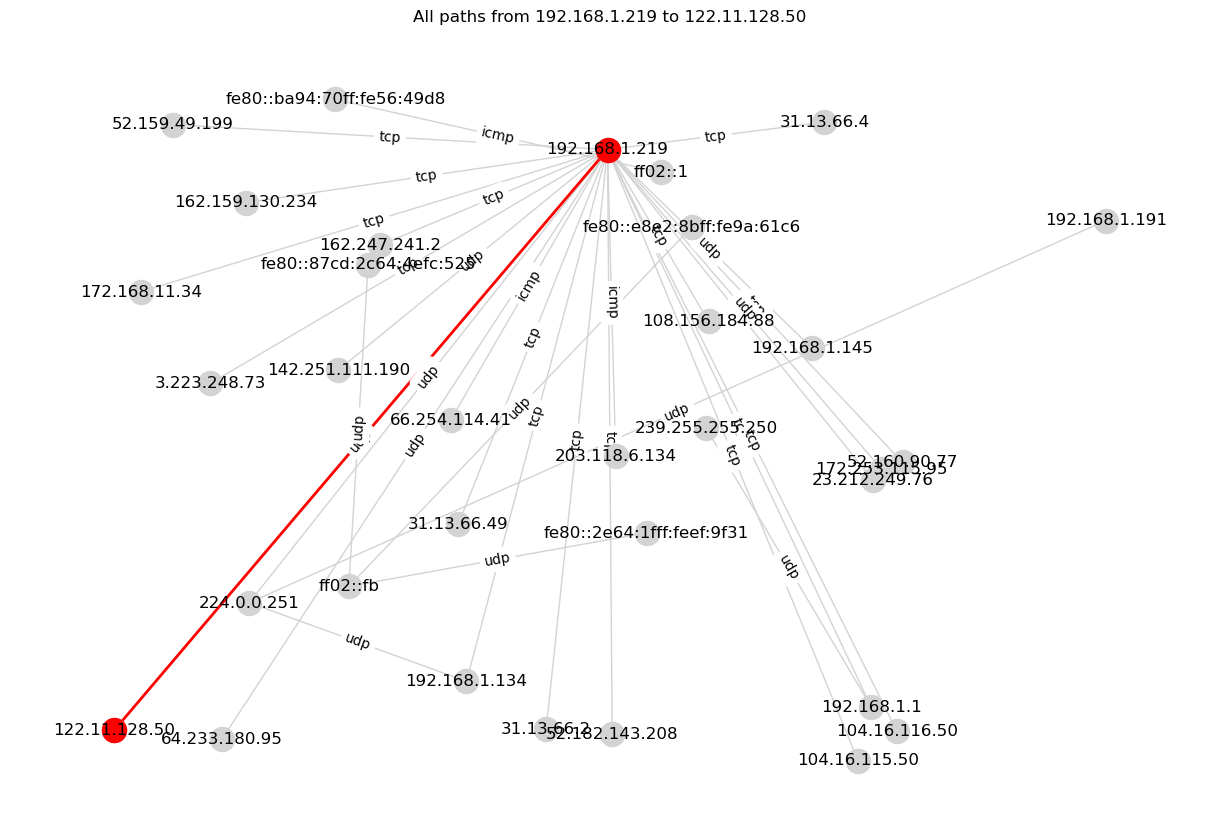

[[IPv4Address('192.168.1.219'), IPv4Address('122.11.128.50')]]

In [22]:
def ip_path(graph, option, data_frame, ip_src, ip_dst):
    # Ensure all IP addresses are strings and strip any leading/trailing spaces
    data_frame['id.orig_h'] = data_frame['id.orig_h'].astype(str).str.strip()
    data_frame['id.resp_h'] = data_frame['id.resp_h'].astype(str).str.strip()
    ip_src = str(ip_src).strip()
    ip_dst = str(ip_dst).strip()

    # Print debug information
    print("DataFrame 'id.orig_h' values:")
    # print(data_frame['id.orig_h'])
    print(f"Checking for source IP: {ip_src}")
    print(f"Checking for destination IP: {ip_dst}")

    src_exist = False
    dst_exist = False
    
    for ip in data_frame['id.orig_h']:
        if (ip == ip_src):
            src_exist = True
    for ip in data_frame['id.resp_h']:
        if (ip == ip_dst):
            dst_exist = True
    
    if (src_exist == True):
        print("The source exists!")
    else:
        print("The source does not exist!")
        return None
    
    if (dst_exist == True):
        print("The destination exists!")
    else:
        print("The destination does not exist!")
        return None
    
    # Convert the source and target IPs to ipaddress objects
    source_ip = ipaddress.ip_address(ip_src)
    target_ip = ipaddress.ip_address(ip_dst)
    edge_proto = nx.get_edge_attributes(graph, 'proto')
    if (option == "shortest"):
        try:
            path = nx.shortest_path(graph, source=source_ip, target=target_ip)
            print(f"Shortest path from {source_ip} to {target_ip}: {path}")

            # Draw the shortest path
            pos = nx.random_layout(graph)  # You can choose any layout you prefer
            plt.figure(figsize=(12, 8))

            # Draw the full graph in light gray
            nx.draw(graph, pos, with_labels=True, node_color='lightgray', edge_color='lightgray')

            # Highlight the nodes and edges in the shortest path
            path_edges = list(zip(path, path[1:]))
            nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=2)
            nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color='red')

            plt.title(f"Shortest path from {source_ip} to {target_ip}")
            plt.show()

            path = nx.shortest_path(graph, source=source_ip, target=target_ip)
            print(f"Shortest path from {source_ip} to {target_ip}: {path}")

            return path
        except nx.NetworkXNoPath:
            print(f"No path exists between {source_ip} and {target_ip}.")
            return None
        except nx.NodeNotFound as e:
            print(e)
            return None
    elif (option == "all"):
        try:
            all_paths = list(nx.all_simple_paths(graph, source=source_ip, target=target_ip))
            print(f"All paths from {source_ip} to {target_ip}: {all_paths}")

            # Draw the paths
            plt.figure(figsize=(12, 8))

            # Draw the full graph in light gray
            pos = nx.random_layout(graph)  # You can choose any layout you prefer
            nx.draw(graph, pos, with_labels=True, node_color='lightgray', edge_color='lightgray')

            # Highlight the nodes and edges in the paths
            for path in all_paths:
                path_edges = list(zip(path, path[1:]))
                for u, v in path_edges:
                    protocol = graph.edges[u, v]['proto']
                    nx.draw_networkx_edges(graph, pos, edgelist=[(u,v)], edge_color='red', width=2, label = protocol)
                    nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color='red')

            edge_labels = {edge: graph.edges[edge]['proto'] for edge in graph.edges}
            nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='black')
            plt.title(f"All paths from {source_ip} to {target_ip}")
            plt.show()

            return all_paths

        except nx.NetworkXNoPath:
            print(f"No path exists between {source_ip} and {target_ip}.")
            return None
        except nx.NodeNotFound as e:
            print(e)
            return None
        
ip_path(graph, "all", data_frame, '192.168.1.219', '122.11.128.50')


{(IPv4Address('192.168.1.1'), IPv4Address('239.255.255.250')): 'udp', (IPv4Address('192.168.1.1'), IPv4Address('192.168.1.219')): 'tcp', (IPv4Address('192.168.1.134'), IPv4Address('224.0.0.251')): 'udp', (IPv4Address('192.168.1.134'), IPv4Address('192.168.1.219')): 'tcp', (IPv4Address('224.0.0.251'), IPv4Address('192.168.1.191')): 'udp', (IPv4Address('224.0.0.251'), IPv4Address('192.168.1.219')): 'udp', (IPv4Address('192.168.1.219'), IPv4Address('3.223.248.73')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('23.212.249.76')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('31.13.66.2')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('31.13.66.4')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('31.13.66.49')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('52.159.49.199')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('52.160.90.77')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('52.182.143.208')): 'tcp', (IPv4Address('192.168.1.219'), IPv4Address('64.233

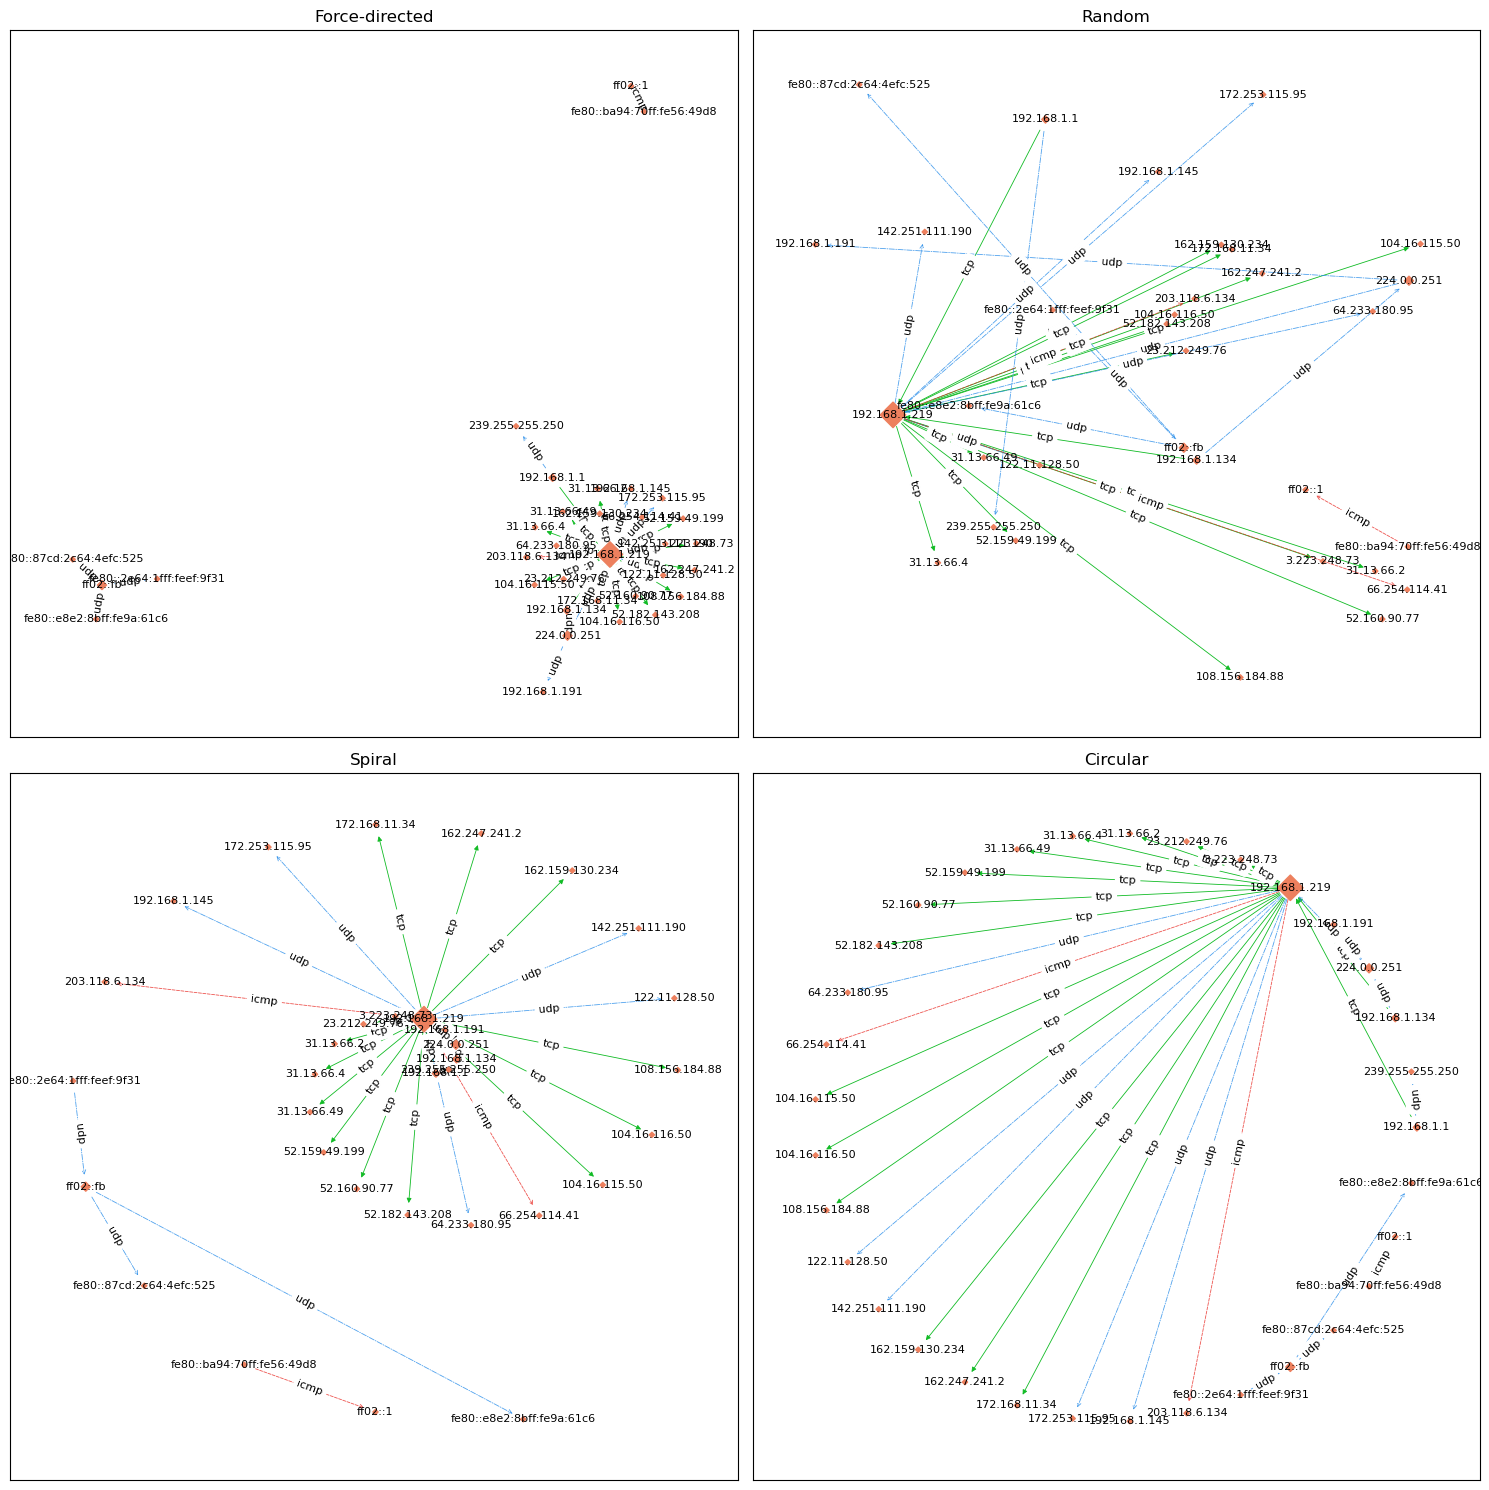

In [23]:
#get edges attribute:
edge_proto = nx.get_edge_attributes(graph, 'proto')
print(edge_proto)

#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")

# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(graph)
    nx.draw_networkx_edges(graph, pos, ax=plot, edgelist=tcp_list, width=lwidth, style=tcp_line_style, edge_color=tcp_color, alpha=tcp_alpha, arrows=True, arrowsize=arrow_size, arrowstyle="-|>")
    nx.draw_networkx_edges(graph, pos, ax=plot, edgelist=udp_list, width=lwidth, style=udp_line_style, edge_color=udp_color, alpha=udp_alpha, arrows=True, arrowsize=arrow_size, arrowstyle="->")
    nx.draw_networkx_edges(graph, pos, ax=plot, edgelist=icmp_list, width=lwidth, style=icmp_line_style, edge_color=icmp_color, alpha=icmp_alpha, arrows=True, arrowsize=arrow_size, arrowstyle="->")
    nx.draw_networkx_edge_labels(graph, pos, ax=plot, font_color=edge_font_color, edge_labels= edge_proto, font_size=font_size)
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, ax=plot, node_color=nodes_color, node_shape="D", nodelist=dict(graph.degree).keys(), node_size=[d * node_dot for d in dict(graph.degree).values()])
    # Draw labels
    nx.draw_networkx_labels(graph, pos, ax=plot, font_color=label_font_color, font_size=font_size)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.tight_layout()
plt.show(block=False)

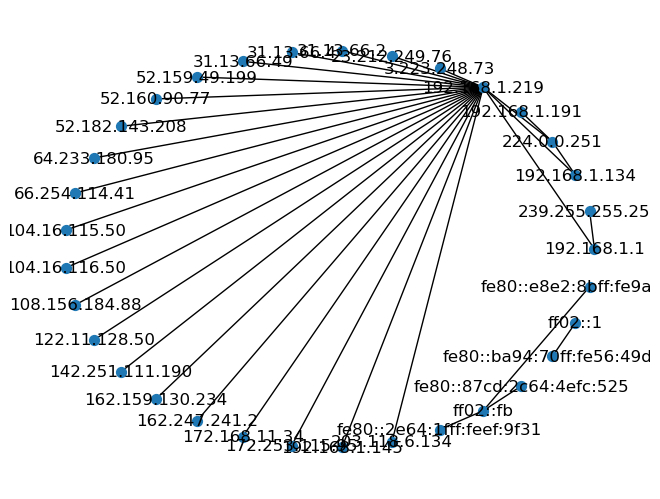

In [24]:
# Draw the graph
nx.draw(graph, pos, with_labels=True, node_size=50)